<h1><center> CURIOSITY-DRIVEN TRADING ALGORITHMS </center></h1>
<h2><center> EXTENSIONS TO THE  RL-LEARNING MODELS </center></h2>

## 1. SOURCES

https://github.com/firmai/financial-machine-learning

https://colab.research.google.com/drive/1FzLCI0AO3c7A4bp9Fi01UwXeoc7BN8sW

## 2. CREATING THE DATA FILE

In [2]:
## Further  recommendation, test multiple frameworks, see what works better on average. 
## Open source RL: https://docs.google.com/spreadsheets/d/1EeFPd-XIQ3mq_9snTlAZSsFY7Hbnmd7P5bbT8LPuMn0/edit#gid=0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
sns.set()

In [3]:

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
df_full = pdr.get_data_yahoo("JPM", start="2018-01-01").reset_index()
df_full.to_csv('JPM.csv',index=False)
df_full.head()


D:\Program Files\Anaconda\lib\site-packages\fix_yahoo_finance\__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



,Date,High,Low,Open,Close,Volume,Adj Close
0,2018-01-02,108.019997,106.809998,107.629997,107.949997,13578800.0,101.684258
1,2018-01-03,108.489998,107.480003,107.860001,108.059998,11901000.0,101.787872
2,2018-01-04,110.029999,108.199997,108.360001,109.040001,12953700.0,103.246048
3,2018-01-05,109.550003,107.779999,109.260002,108.339996,14155000.0,102.583244
4,2018-01-08,108.680000,107.699997,108.150002,108.500000,12466500.0,102.734734


In [4]:
df_full = pd.read_csv('JPM.csv')

## 3. MODELING THE INVESTMENT  AGENTS

###  3.1. CONCEPTUAL FRAMEWORK

See **Simonini, T (2018). `Curiosity Driven Learning Made Easy`** , found at https://towardsdatascience.com/curiosity-driven-learning-made-easy-part-i-d3e5a2263359

In the recent years, we’ve seen a lot of innovations in Deep Reinforcement Learning. From DeepMind and the Deep Q learning architecture in 2014 to OpenAI playing Dota2 with OpenAI five in 2018, we live in an exciting and promising moment.

And today we’ll learn about Curiosity-Driven Learning, one of the most exciting and promising strategy in Deep Reinforcement Learning.

Reinforcement Learning is based on the reward hypothesis, which is the idea that each goal can be described as the maximization of the rewards. However, the current problem of extrinsic rewards (aka rewards given by the environment) is that this function is hard coded by a human, which is not scalable.

The idea of Curiosity-Driven learning, **is to build a reward function that is intrinsic to the agent** (generated by the agent itself). It means that the agent will be a self-learner since he will be the student but also the feedback master.

Sounds crazy? Yes but that’s a genius idea that was re-introduced in the 2017 paper Curiosity-driven Exploration by Self-supervised Prediction. The results were then improved with the second paper Large-Scale Study of Curiosity-Driven Learning.
See **Scmidhuber, J (2014)** at http://people.idsia.ch/~juergen/interest.html

#### ADDRESSING SOME OF THE SHORTFALLS OF REINFORCEMENT LEARNING
First, the sparse rewards or non-existing rewards problem: that is, most rewards do not contain information, and hence are set to zero. However, as rewards act as feedback for RL agents, if they don’t receive any, their knowledge of which action is appropriate (or not) cannot change.

For instance, in Vizdoom “DoomMyWayHome,” your agent is only rewarded if it finds the vest. However, the vest is far away from your starting point, so most of your rewards will be zero.

Therefore, if our agent does not receive useful feedback (dense rewards), it will take much longer to learn an optimal policy.
The second big problem is that the extrinsic reward function is handmade — that is, in each environment, a human has to implement a reward function. But how we can scale that in big and complex environments?



### 3.13 CURIOSITY Q-LEARNING AGENT

In [5]:
## Curiosity Q-learning agent

from collections import deque
import random


df= df_full.copy()
name = 'Curiosity Q-learning agent'

class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.Y = tf.placeholder(tf.float32, (None, self.state_size))
        self.ACTION = tf.placeholder(tf.float32, (None))
        self.REWARD = tf.placeholder(tf.float32, (None))
        self.batch_size = tf.shape(self.ACTION)[0]
        
        with tf.variable_scope('curiosity_model'):
            action = tf.reshape(self.ACTION, (-1,1))
            state_action = tf.concat([self.X, action], axis=1)
            save_state = tf.identity(self.Y)
            
            feed = tf.layers.dense(state_action, 32, activation=tf.nn.relu)
            self.curiosity_logits = tf.layers.dense(feed, self.state_size)
            self.curiosity_cost = tf.reduce_sum(tf.square(save_state - self.curiosity_logits), axis=1)
            
            self.curiosity_optimizer = tf.train.RMSPropOptimizer(self.LEARNING_RATE)\
            .minimize(tf.reduce_mean(self.curiosity_cost))
        
        total_reward = tf.add(self.curiosity_cost, self.REWARD)
        
        with tf.variable_scope("q_model"):
            with tf.variable_scope("eval_net"):
                x_action = tf.layers.dense(self.X, 128, tf.nn.relu)
                self.logits = tf.layers.dense(x_action, self.OUTPUT_SIZE)
            
            with tf.variable_scope("target_net"):
                y_action = tf.layers.dense(self.Y, 128, tf.nn.relu)
                y_q = tf.layers.dense(y_action, self.OUTPUT_SIZE)
            
            q_target = total_reward + self.GAMMA * tf.reduce_max(y_q, axis=1)
            action = tf.cast(self.ACTION, tf.int32)
            action_indices = tf.stack([tf.range(self.batch_size, dtype=tf.int32), action], axis=1)
            q = tf.gather_nd(params=self.logits, indices=action_indices)
            self.cost = tf.losses.mean_squared_error(labels=q_target, predictions=q)
            self.optimizer = tf.train.RMSPropOptimizer(self.LEARNING_RATE).minimize(
            self.cost, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "q_model/eval_net"))
            
        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_model/target_net')
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_model/eval_net')
        self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action
    
    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        actions = np.array([a[1] for a in replay])
        rewards = np.array([a[2] for a in replay])
        new_states = np.array([a[3] for a in replay])
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.target_replace_op)
            
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict = {
            self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards
        })
        
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.curiosity_optimizer, feed_dict = {
                self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards
            })
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                state = next_state
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)



Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 480.989983.3, cost: 51.814709, total money: 4741.989975
epoch: 20, total rewards: 528.420036.3, cost: 186.874359, total money: 5116.930054
epoch: 30, total rewards: 37.669960.3, cost: 194.454437, total money: 8686.969955
epoch: 40, total rewards: 237.729973.3, cost: 1060.444336, total money: 8760.449974
epoch: 50, total rewards: 704.639984.3, cost: 3973.605957, total money: 5554.899994
epoch: 60, total rewards: 201.290024.3, cost: 1103.337280, total money: 8876.180016
epoch: 70, total rewards: 131.729958.3, cost: 11612.878906, total money: 9356.699951
epoch: 80, total rewards: 150.139931.3, cost: 3951.322754, total money: 10028.619934
epoch: 90, total rewards: 794.620049.3, cost: 7557.618164, total money: 1470.750046

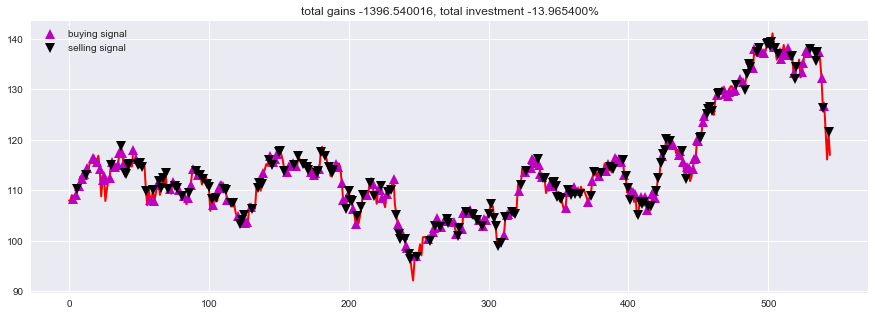

In [7]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
#plt.savefig('output/'+name+'.png')
plt.show()